Usando dispositivo: cuda


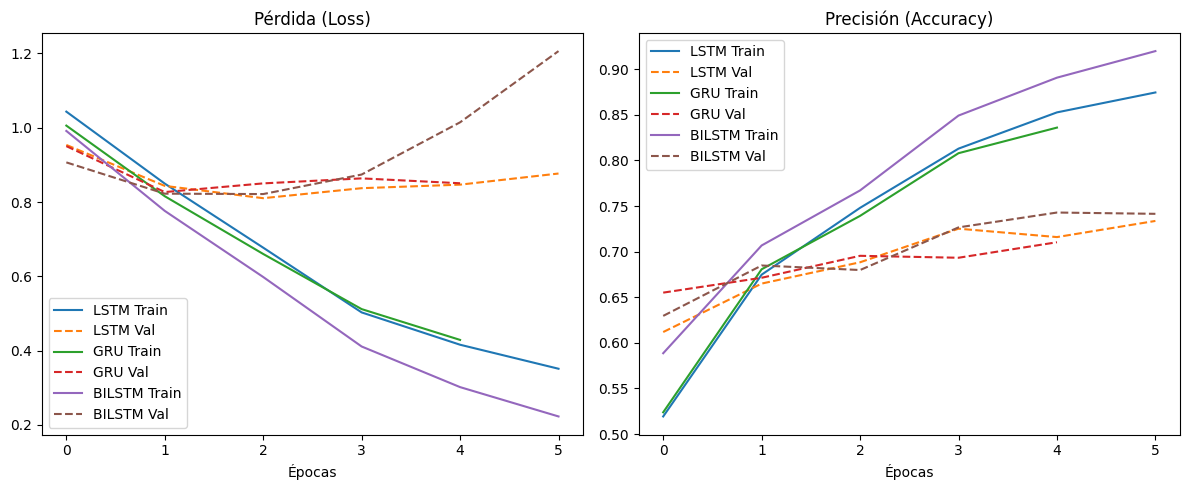

Cargando modelo desde: models/lstm_best_model.pth

Cargando Test Set...

Realizando predicciones sobre Test Set...

 REPORTE DE CLASIFICACIÓN (TEST SET)
              precision    recall  f1-score   support

     Bajista       0.43      0.58      0.49       208
     Alcista       0.47      0.63      0.54       279
     Neutral       0.86      0.71      0.78       927

    accuracy                           0.68      1414
   macro avg       0.59      0.64      0.60      1414
weighted avg       0.72      0.68      0.69      1414



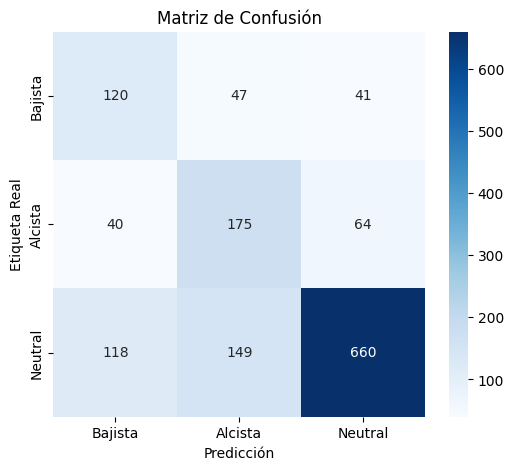


=== PRUEBAS EN VIVO ===
------------------------------------------------------------
Texto: The market is crashing hard, everything is red!
Predicción: Neutral (2)
------------------------------------------------------------
------------------------------------------------------------
Texto: Apple reported amazing earnings, stock is flying to the moon
Predicción: Alcista (1)
------------------------------------------------------------
------------------------------------------------------------
Texto: The fed will announce interest rates tomorrow, market is waiting
Predicción: Neutral (2)
------------------------------------------------------------


In [1]:
# =============================================================================
# NOTEBOOK 3: EVALUACIÓN E INFERENCIA (VERSIÓN FINAL CORREGIDA)
# =============================================================================

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------------------------------------------------------
# CONFIGURACIÓN GENERAL
# -----------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "data_processed"
MODELS_DIR = "models"
ID2LABEL = {0: "Bajista", 1: "Alcista", 2: "Neutral"}

# Debe coincidir con Notebook 2
MAX_LEN = 40  

print(f"Usando dispositivo: {DEVICE}")

# -----------------------------------------------------------------------------
# 1. TOKENIZACIÓN AVANZADA (MISMO FORMATO DEL NOTEBOOK 2)
# -----------------------------------------------------------------------------
def basic_tokenize(text):
    return str(text).lower().split()

def encode_text(text, vocab):
    tokens = basic_tokenize(text)
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]
    return torch.tensor(ids, dtype=torch.long)

class FinancialTweetsDataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab):
        self.df = df
        self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]["text"]
        label = int(self.df.iloc[idx]["label"])
        encoded = encode_text(text, self.vocab)
        return encoded, label

def collate_fn(batch):
    """Padding dinámico EXACTAMENTE igual que en Notebook 2."""
    texts, labels = zip(*batch)
    lengths = [len(t) for t in texts]
    max_len = min(MAX_LEN, max(lengths))

    padded = []
    for seq in texts:
        seq = seq[:max_len]
        if len(seq) < max_len:
            seq = torch.cat([seq, torch.tensor([PAD_IDX] * (max_len - len(seq)))])
        padded.append(seq)

    padded = torch.stack(padded)
    labels = torch.tensor(labels, dtype=torch.long)
    lengths = torch.tensor([min(l, max_len) for l in lengths], dtype=torch.long)

    return padded, labels, lengths

# -----------------------------------------------------------------------------
# 2. MODELO COMPLETO (MISMO QUE NOTEBOOK 2)
# -----------------------------------------------------------------------------
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_output, mask):
        # rnn_output: (batch, seq, hidden)
        scores = self.attn(rnn_output).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(rnn_output * attn_weights.unsqueeze(-1), dim=1)
        return context

class RecurrentClassifier(nn.Module):
    def __init__(self, model_type, vocab_size, embed_dim, hidden_dim, out_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.model_type = model_type

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        is_bi = (model_type == "bilstm")
        num_directions = 2 if is_bi else 1

        if model_type in ["lstm", "bilstm"]:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers,
                               batch_first=True, dropout=dropout if n_layers > 1 else 0,
                               bidirectional=is_bi)
        else:
            self.rnn = nn.GRU(embed_dim, hidden_dim, n_layers,
                              batch_first=True, dropout=dropout if n_layers > 1 else 0,
                              bidirectional=is_bi)

        self.attention = AttentionPooling(hidden_dim * num_directions)
        self.fc = nn.Linear(hidden_dim * num_directions, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx

    def forward(self, x, lengths):
        # Máscara original basada en padding
        mask = (x != self.pad_idx).float()   # (batch, MAX_LEN)

        # Embedding
        emb = self.embedding(x)

        # Empaquetar secuencias
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # RNN
        packed_out, _ = self.rnn(packed)

        # Desempaquetar secuencias
        rnn_out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        # rnn_out → (batch, seq_real, hidden_dim * num_directions)

        # --- CORRECCIÓN CLAVE: ajustar máscara al tamaño real ---
        seq_len = rnn_out.size(1)
        mask = mask[:, :seq_len]     # Recortar máscara a la longitud real
        # ---------------------------------------------------------------------

        # Atención
        context = self.attention(rnn_out, mask)
        logits = self.fc(self.dropout(context))
        return logits

# -----------------------------------------------------------------------------
# 3. CARGA DE MODELO DESDE CHECKPOINT
# -----------------------------------------------------------------------------
def load_model(path):
    print(f"Cargando modelo desde: {path}")
    checkpoint = torch.load(path, map_location=DEVICE)
    vocab = checkpoint["vocab"]
    conf = checkpoint["config"]

    global PAD_IDX
    PAD_IDX = vocab["<PAD>"]

    model = RecurrentClassifier(
        model_type=conf["model_type"],
        vocab_size=len(vocab),
        embed_dim=conf["embed_dim"],
        hidden_dim=conf["hidden_dim"],
        out_dim=3,
        n_layers=conf["n_layers"],
        dropout=conf["dropout"],
        pad_idx=PAD_IDX
    )

    model.load_state_dict(checkpoint["model_state"])
    model.to(DEVICE)
    model.eval()
    return model, vocab

# -----------------------------------------------------------------------------
# 4. GRAFICAR HISTORIA DE ENTRENAMIENTO
# -----------------------------------------------------------------------------
histories = pickle.load(open(f"{MODELS_DIR}/history.pkl", "rb"))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for m_name, h in histories.items():
    plt.plot(h["train_loss"], label=f"{m_name.upper()} Train")
    plt.plot(h["val_loss"], "--", label=f"{m_name.upper()} Val")
plt.title("Pérdida (Loss)")
plt.xlabel("Épocas")
plt.legend()

plt.subplot(1, 2, 2)
for m_name, h in histories.items():
    plt.plot(h["train_acc"], label=f"{m_name.upper()} Train")
    plt.plot(h["val_acc"], "--", label=f"{m_name.upper()} Val")
plt.title("Precisión (Accuracy)")
plt.xlabel("Épocas")
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 5. EVALUACIÓN EN TEST SET
# -----------------------------------------------------------------------------
model_path = f"{MODELS_DIR}/lstm_best_model.pth"
model, vocab = load_model(model_path)

print("\nCargando Test Set...")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

test_ds = FinancialTweetsDataset(test_df, vocab)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=128, shuffle=False, collate_fn=collate_fn
)

def get_predictions_and_labels(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb, lengths in loader:
            xb, yb, lengths = xb.to(DEVICE), yb.to(DEVICE), lengths.to(DEVICE)
            logits = model(xb, lengths)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds)

print("\nRealizando predicciones sobre Test Set...")
y_true, y_pred = get_predictions_and_labels(model, test_loader)

print("\n" + "="*50)
print(" REPORTE DE CLASIFICACIÓN (TEST SET)")
print("="*50)
print(classification_report(
    y_true, y_pred, target_names=["Bajista", "Alcista", "Neutral"]
))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Bajista", "Alcista", "Neutral"],
    yticklabels=["Bajista", "Alcista", "Neutral"]
)
plt.ylabel("Etiqueta Real")
plt.xlabel("Predicción")
plt.title("Matriz de Confusión")
plt.show()

# -----------------------------------------------------------------------------
# 6. INFERENCIA INTERACTIVA
# -----------------------------------------------------------------------------
def predict_single_text(model, text, vocab, max_len=MAX_LEN):
    tokens = basic_tokenize(text)
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]
    length = min(len(ids), max_len)
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))

    x = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([length], dtype=torch.long).to(DEVICE)

    model.eval()
    with torch.no_grad():
        logits = model(x, lengths)
        pred_idx = torch.argmax(logits, dim=1).item()
    return pred_idx

def analizar_frase(texto):
    pred_idx = predict_single_text(model, texto, vocab)
    etiqueta = ID2LABEL[pred_idx]
    print("-" * 60)
    print(f"Texto: {texto}")
    print(f"Predicción: {etiqueta} ({pred_idx})")
    print("-" * 60)

print("\n=== PRUEBAS EN VIVO ===")
analizar_frase("The market is crashing hard, everything is red!")
analizar_frase("Apple reported amazing earnings, stock is flying to the moon")
analizar_frase("The fed will announce interest rates tomorrow, market is waiting")
